In [1]:
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 36})
rc('text', usetex=True)

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import functools
import math
from scipy.linalg import qr

plt.rcParams.update({'font.size': 45})

In [2]:
# Set random positive-definite matrix
n=200
mu = 0.001
diag = np.random.rand(n)
diag = diag*(1-mu) + mu
D = np.diag(diag)
D = np.diag(diag)

R = np.random.rand(n,n)

Q, _ = qr(R)

M = Q.dot(D).dot(Q.T)

# Objective function
def f(x):
    return x.T.dot(M).dot(x)/2.0
def L2(x):
    return np.sqrt(x.dot(x))

In [3]:
C = 1

# Discretization interval
h = 1/C

# Range of time
time = int(1000)
discrete_time = int(time*C)

dpi=100

# Coefficients
eps = 0.0001
def A(t):
    return (t+eps)*(t+eps)/4
def s(t):
    return h*h*(2*t+2*eps+h)*(2*t+2*eps+h)/(t+eps+h)/(t+eps+h)/4
def b(t):
    return (2*t+2*eps+h)*(t-h+eps)*(t-h+eps)/(2*t+2*eps-h)/(t+h+eps)/(t+h+eps)
def a(t):
    return h*(2*t+2*eps+h)/(t+eps+h)/(t+eps+h)
def L2(x):
    return np.linalg.norm(x)
    
t = np.linspace(0, time, time+1)

# start point
start= np.random.rand(n)

In [4]:
#Calculate Nesterov's method (NAG-C)
def Nesterov1(time):
    Nes = np.zeros((time+1,n))
    Nes[0] = start
    for k in range(time):
        if k==0:
            y = Nes[k]
        else:
            y = Nes[k] + (Nes[k]-Nes[k-1])* b(h*k)
        Nes[k+1] = y -  s(h*k) * M.dot(y)
    return Nes

In [5]:
#Calculate Nesterov's method (NAG-C) with restarting scheme
def Nesterov2(time, kmin=20):
    Nes = np.zeros((time+1,n))
    Nes[0] = start
    j = 1
    for k in range(time):
        if k==0:
            y = Nes[k]
        else:
            y = Nes[k] + (Nes[k]-Nes[k-1])* b(h*j)
        Nes[k+1] = y -  s(h*j) * M.dot(y)
        if np.dot(Nes[k+1]-2*Nes[k]+Nes[k-1], Nes[k]-Nes[k-1]) < 0 and j>= kmin:
            j = 1
            Nes[k+1] = Nes[k] -  s(h*j) * M.dot(Nes[k]) 
        else:
            j = j+1
    return Nes

In [6]:
Nes1 = Nesterov1(time)
Nes2 = Nesterov2(time)
Nes1_func = np.apply_along_axis(f, 1, Nes1)
Nes2_func = np.apply_along_axis(f, 1, Nes2)

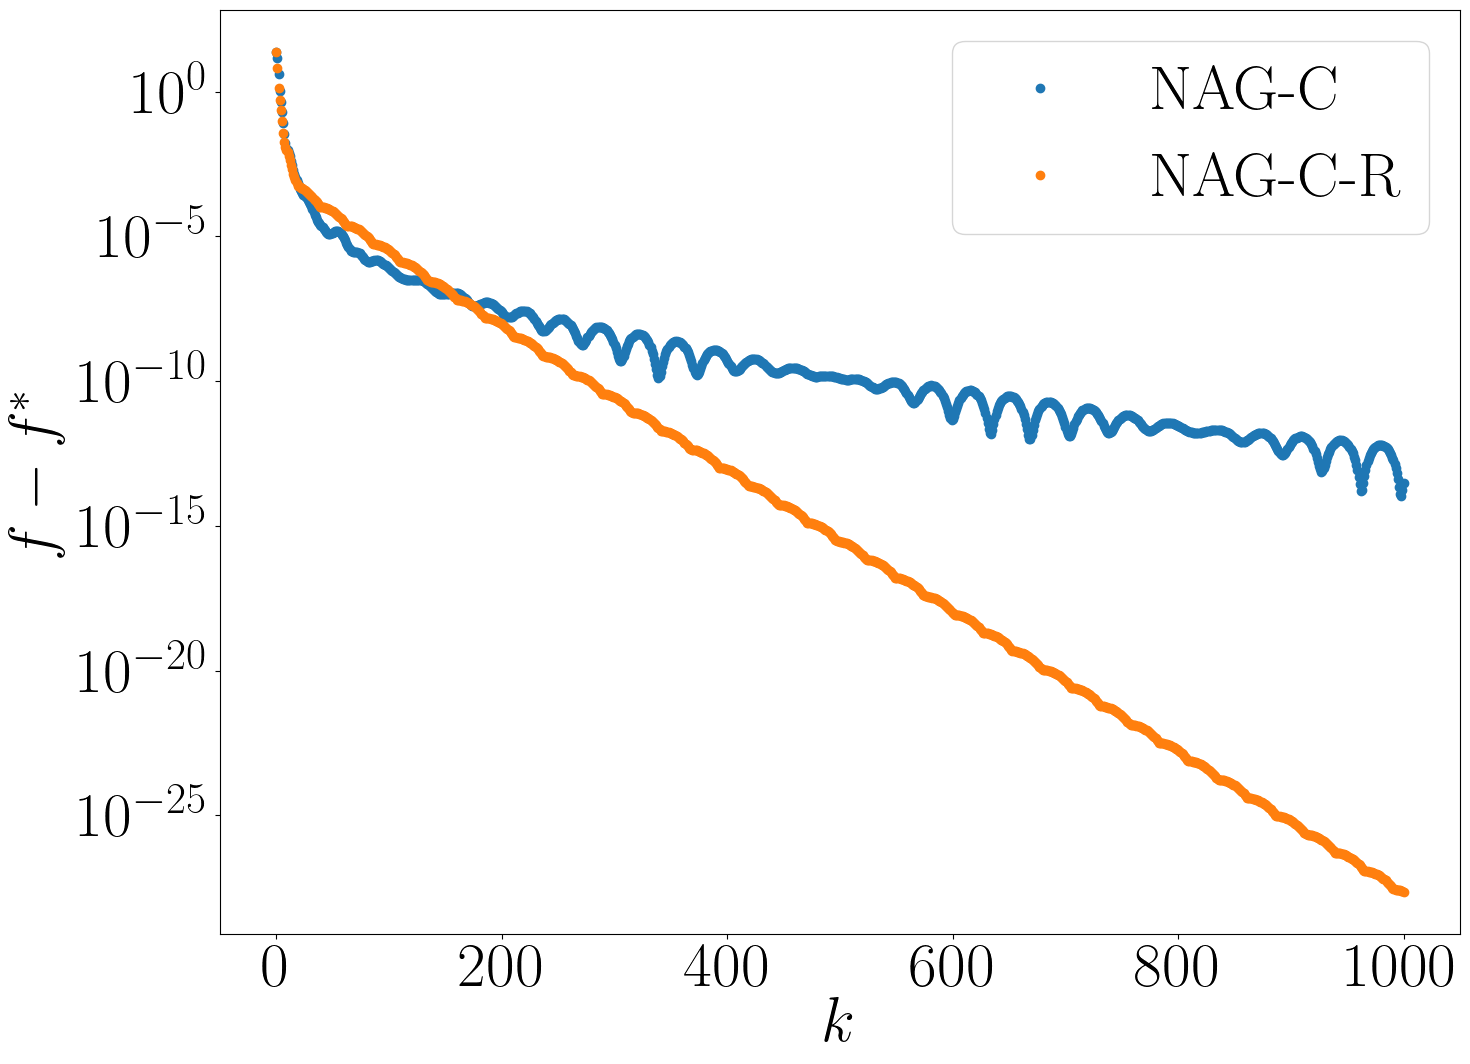

In [7]:
plt.figure(figsize=(16,12))
plt.plot(t, Nes1_func, '.', label="NAG-C", markersize=12)
plt.plot(t, Nes2_func, '.', label="NAG-C-R", markersize=12)
plt.xlabel('$k$', labelpad=0)
plt.ylabel('$f-f^*$', labelpad=10)
plt.yscale('log')
plt.legend()
plt.savefig('Restarting_CV_M.png', dpi=dpi, bbox_inches = 'tight', pad_inches = 0)
plt.show()